Step 1: Ready the data.  This data has previously been scraped from the aforementioned web site by the crowd_level_scraper_csv.py python application into a csv.  This spreadsheet was scraped from the
"Queue Times" web site.

Note that only open dates are in the data set.

In [1]:
import pandas as pd
from pathlib import Path
from cpml.predictive.data_loader import load_crowd_csv
from cpml.common.logging import configure_logging

# setup logging
configure_logging()  # default level is INFO


BASE_DIR = Path.cwd().parents[1]
STORAGE_DIR = BASE_DIR / "storage"
print(f"Base Dir: {BASE_DIR}")
print(f"Storage Dir: {STORAGE_DIR}")
cp_df: pd.DataFrame = load_crowd_csv(STORAGE_DIR / "crowd_level.csv")
cp_df.head()

Base Dir: C:\Users\rober\PycharmProjects\CedarPointMLModel
Storage Dir: C:\Users\rober\PycharmProjects\CedarPointMLModel\storage


,date,crowd_level,actual_temp,actual_rain,actual_wind,forecast_temp,forecast_rain,forecast_wind
0,2016-05-07,64.0,18.5,0.00,NaN,NaN,NaN,NaN
1,2016-05-08,25.0,16.9,0.00,NaN,NaN,NaN,NaN
2,2016-05-13,26.0,17.7,0.00,NaN,NaN,NaN,NaN
3,2016-05-14,76.0,9.1,0.03,NaN,NaN,NaN,NaN
4,2016-05-15,40.0,8.4,0.01,NaN,NaN,NaN,NaN


In [2]:
cp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198 entries, 0 to 1197
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1198 non-null   object 
 1   crowd_level    1198 non-null   float64
 2   actual_temp    1198 non-null   float64
 3   actual_rain    1198 non-null   float64
 4   actual_wind    0 non-null      float64
 5   forecast_temp  707 non-null    float64
 6   forecast_rain  707 non-null    float64
 7   forecast_wind  707 non-null    float64
dtypes: float64(7), object(1)
memory usage: 75.0+ KB


Step 2.  Evaluate the data for issues with missing data or errors and address them.

In [3]:
cp_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,1198,1198,2024-11-02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
crowd_level,1198.0,NaN,NaN,NaN,49.566778,28.92346,0.0,25.0,49.0,75.0,100.0
actual_temp,1198.0,NaN,NaN,NaN,22.654674,4.913471,4.1,20.4,23.65,26.0,32.4
actual_rain,1198.0,NaN,NaN,NaN,0.140401,0.404351,0.0,0.0,0.0,0.0575,3.9
actual_wind,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
forecast_temp,707.0,NaN,NaN,NaN,22.740736,4.876766,3.4,20.4,23.8,26.1,33.1
forecast_rain,707.0,NaN,NaN,NaN,0.17512,0.370718,0.0,0.0,0.01,0.17,3.26
forecast_wind,707.0,NaN,NaN,NaN,4.68133,2.011297,1.5,3.1,4.4,6.1,14.0


In [4]:
cp_df.isnull().sum()

date                0
crowd_level         0
actual_temp         0
actual_rain         0
actual_wind      1198
forecast_temp     491
forecast_rain     491
forecast_wind     491
dtype: int64

For various weather related items where an actual exists and a forecast does not, substitute the forecast with the actual


In [5]:
from cpml.predictive.preprocess import fill_forecast_and_actual

cp_df = fill_forecast_and_actual(cp_df)
cp_df[["actual_temp", "forecast_temp"]].head()

,actual_temp,forecast_temp
0,65.30,65.30
1,62.42,62.42
2,63.86,63.86
3,48.38,48.38
4,47.12,47.12


Add discrete columns for year/month/day from string date in format yyyy-mm-dd.  Convert date column to true date.

In [6]:
from cpml.predictive.preprocess import add_date_parts

cp_df = add_date_parts(cp_df)
cp_df.head()


,date,crowd_level,actual_temp,actual_rain,actual_wind,forecast_temp,forecast_rain,forecast_wind,year,month,day
0,2016-05-07,64.0,65.30,0.00,NaN,65.30,0.00,NaN,2016,5,7
1,2016-05-08,25.0,62.42,0.00,NaN,62.42,0.00,NaN,2016,5,8
2,2016-05-13,26.0,63.86,0.00,NaN,63.86,0.00,NaN,2016,5,13
3,2016-05-14,76.0,48.38,0.03,NaN,48.38,0.03,NaN,2016,5,14
4,2016-05-15,40.0,47.12,0.01,NaN,47.12,0.01,NaN,2016,5,15


In [7]:
# how many missing in actual_wind
cp_df["actual_wind"].isna().sum()

np.int64(491)

Look at how many wind values are missing by year...

In [8]:
cp_df[cp_df['actual_wind'].isnull()].groupby(cp_df['year'], as_index=False)['year'].size()

,year,size
0,2016,141
1,2017,140
2,2018,141
3,2019,68
4,2023,1


Wind values are missing for the first 3 years and part of the 4th (and one outlier in 2023).  Evaluate whether or not the wind has any real importance.

In [9]:
from cpml.predictive.evaluate import feature_importance
importances = feature_importance(cp_df, label="crowd_level", drop_cols=("date",))
print(importances)



day              0.166425
actual_temp      0.158335
forecast_temp    0.141949
year             0.125169
month            0.110227
forecast_rain    0.088437
actual_rain      0.071271
actual_wind      0.069446
forecast_wind    0.068742
Name: importance, dtype: float64


Wind columns appear to be the least valuable feature.  As a result, since there is no good way to impute the values we will just drop them as features.

In [10]:
from cpml.predictive.constants import LOW_VALUE_FEATURES
from cpml.predictive.preprocess import drop_low_value_features

cp_df = drop_low_value_features(cp_df, LOW_VALUE_FEATURES)


2025-11-13 15:45:31 [INFO] cpml.predictive.preprocess: Dropping low-value columns: ['actual_wind', 'forecast_wind']


### Data enrichment

Add dates that may be of importance for cedar point attendance.  Specifically we will look:
- Holidays
- Special Cedar Point events (opening day, CoasterMania, closing date)
- Halloweekend

And we will also consider
- if school is in session
- day of the week (range is 0-6, Sunday is 0)
- week number within the general Cedar Point opening timeframe.

In [11]:
from cpml.predictive.preprocess import add_calendar_features
cp_df = add_calendar_features(cp_df)

cp_df.head(20)

,date,crowd_level,actual_temp,actual_rain,forecast_temp,forecast_rain,year,month,day,labor_day,...,fourth_of_july,fathers_day,mothers_day,hallowweekend,school_season,opening_day,closing_day,coaster_mania,day_of_week,season_week
0,2016-05-07,64.0,65.30,0.00,65.30,0.00,2016,5,7,False,...,False,False,False,False,True,True,False,False,5,1
1,2016-05-08,25.0,62.42,0.00,62.42,0.00,2016,5,8,False,...,False,False,True,False,True,False,False,False,6,1
2,2016-05-13,26.0,63.86,0.00,63.86,0.00,2016,5,13,False,...,False,False,False,False,True,False,False,False,4,1
3,2016-05-14,76.0,48.38,0.03,48.38,0.03,2016,5,14,False,...,False,False,False,False,True,False,False,False,5,2
4,2016-05-15,40.0,47.12,0.01,47.12,0.01,2016,5,15,False,...,False,False,False,False,True,False,False,False,6,2
5,2016-05-16,38.0,61.52,0.00,61.52,0.00,2016,5,16,False,...,False,False,False,False,True,False,False,False,0,2
6,2016-05-17,27.0,56.30,0.06,56.30,0.06,2016,5,17,False,...,False,False,False,False,True,False,False,False,1,2
7,2016-05-18,24.0,57.02,0.00,57.02,0.00,2016,5,18,False,...,False,False,False,False,True,False,False,False,2,2
8,2016-05-19,14.0,62.96,0.00,62.96,0.00,2016,5,19,False,...,False,False,False,False,True,False,False,False,3,2
9,2016-05-20,26.0,60.44,0.07,60.44,0.07,2016,5,20,False,...,False,False,False,False,True,False,False,False,4,2


Look for outliers on the crowd level...

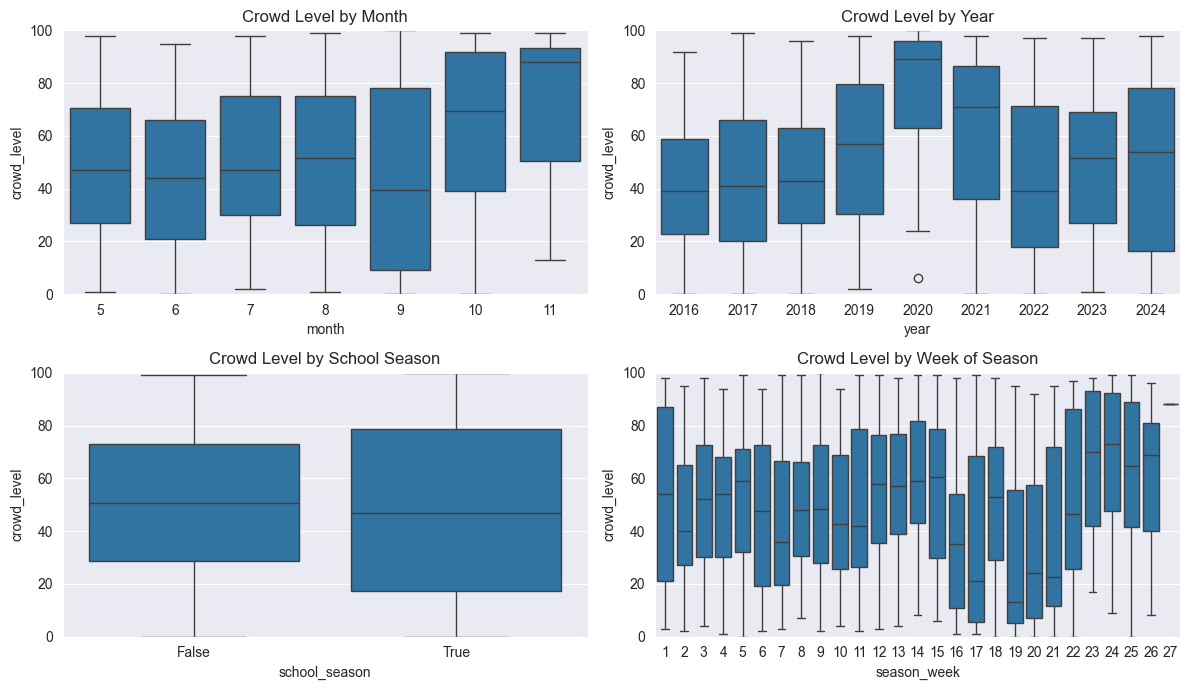

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 2, ncols=2, figsize=(12,7))
axes = axes.flatten()  # make it easy to iterate
for ax in axes:
    ax.set_ylim(0, cp_df["crowd_level"].max())
titles = [
    "Crowd Level by Month",
    "Crowd Level by Year",
    "Crowd Level by School Season",
    "Crowd Level by Week of Season"
]
for ax, title in zip(axes, titles):
    ax.set_title(title)


sns.boxplot(data=cp_df, x='month', y='crowd_level', ax=axes[0])
sns.boxplot(data=cp_df, x='year', y='crowd_level', ax=axes[1])
sns.boxplot(data=cp_df, x='school_season', y='crowd_level', ax=axes[2])
sns.boxplot(data=cp_df, x='season_week', y='crowd_level', ax=axes[3])

plt.tight_layout()
plt.show()


### Outliers
Based on the information above, the most obvious outlier is year 2020 which makes sense (COVID).  For the purpose of our analysis we will drop it.

In addition, for the purpose of our analysis we are not doing year to year trends (which have impact from features outside the scope of this such as new rides).  So we will drop the year from our dataframe for usage.

In [13]:
from cpml.predictive.preprocess import remove_year
cp_df = remove_year(cp_df)
cp_df.head()

,date,crowd_level,actual_temp,actual_rain,forecast_temp,forecast_rain,month,day,labor_day,memorial_day,fourth_of_july,fathers_day,mothers_day,hallowweekend,school_season,opening_day,closing_day,coaster_mania,day_of_week,season_week
0,2016-05-07,64.0,65.30,0.00,65.30,0.00,5,7,False,False,False,False,False,False,True,True,False,False,5,1
1,2016-05-08,25.0,62.42,0.00,62.42,0.00,5,8,False,False,False,False,True,False,True,False,False,False,6,1
2,2016-05-13,26.0,63.86,0.00,63.86,0.00,5,13,False,False,False,False,False,False,True,False,False,False,4,1
3,2016-05-14,76.0,48.38,0.03,48.38,0.03,5,14,False,False,False,False,False,False,True,False,False,False,5,2
4,2016-05-15,40.0,47.12,0.01,47.12,0.01,5,15,False,False,False,False,False,False,True,False,False,False,6,2


#### Look at general crowd level pattern across the board


<Axes: xlabel='count', ylabel='crowd_level'>

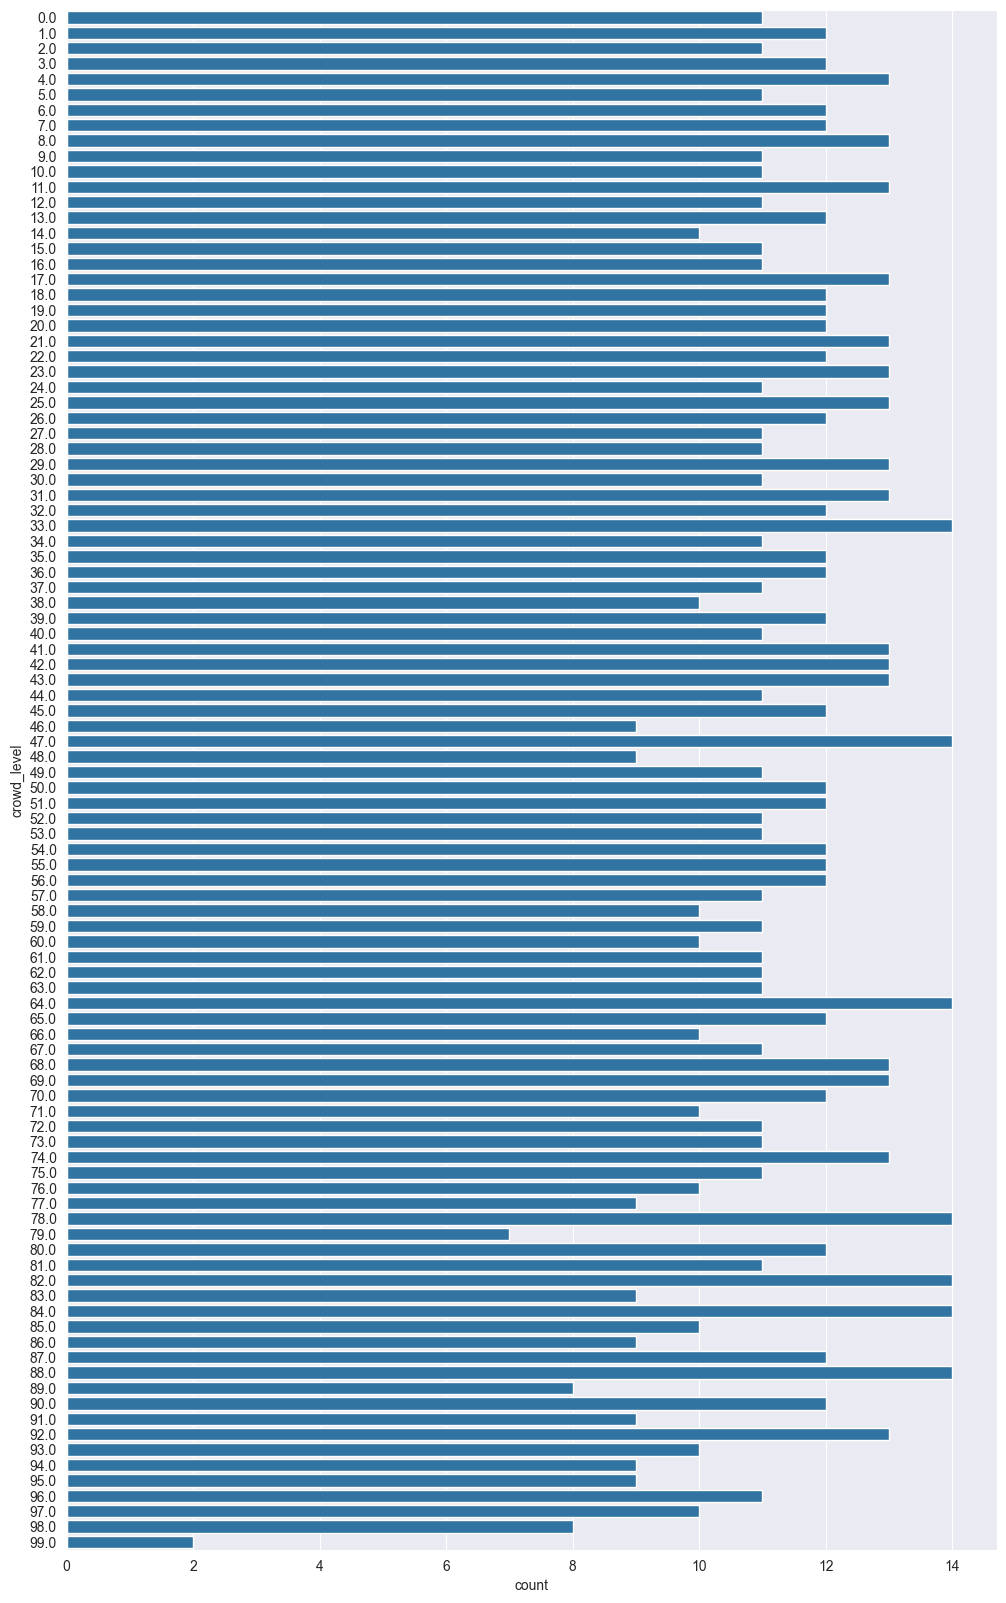

In [14]:
plt.figure(figsize=(12,20))
sns.countplot(data=cp_df, y='crowd_level')


Crowd level seems evenly split, reasonable...

### Begin and evaluate various models.

In [15]:
cp_df.isna().any()

date              False
crowd_level       False
actual_temp       False
actual_rain       False
forecast_temp     False
forecast_rain     False
month             False
day               False
labor_day         False
memorial_day      False
fourth_of_july    False
fathers_day       False
mothers_day       False
hallowweekend     False
school_season     False
opening_day       False
closing_day       False
coaster_mania     False
day_of_week       False
season_week       False
dtype: bool

In [16]:
from pathlib import Path
from datetime import datetime
import time
import pandas as pd

from cpml.predictive.preprocess import prepare_for_modeling
from cpml.predictive.models import MODEL_CLASSES   # registry
from cpml.common.logging import get_logger

logger = get_logger("predictive.train.nb")

# ---- data ----
cp_model_df = prepare_for_modeling(cp_df)

# ---- run setup ----
RUN_TAG = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
OUT_ROOT = Path(STORAGE_DIR) / "artifacts" / f"run_{RUN_TAG}"
OUT_ROOT.mkdir(parents=True, exist_ok=True)

results = []
for ModelCls in MODEL_CLASSES:
    name = ModelCls.__name__
    try:
        m = ModelCls()
        t0 = time.perf_counter()
        m.create_model(cp_model_df.copy())           # trains; fills m.feature_names_ and m.metrics
        fit_s = time.perf_counter() - t0

        # Save each trained model + .meta.json into its own folder
        model_dir = OUT_ROOT / name
        model_dir.mkdir(parents=True, exist_ok=True)
        m.save_model(model_dir)

        r2   = (m.metrics or {}).get("r2")
        rmse = (m.metrics or {}).get("rmse")

        results.append({
            "Model": name,
            "Serializer": getattr(m, "DEFAULT_SERIALIZER", None),
            "R2": r2,
            "RMSE": rmse,
            "FitSeconds": round(fit_s, 3),
            "Path": str(model_dir),
            "Features": ",".join(m.feature_names_ or []),
        })
        logger.info("Trained %-28s R2=%s RMSE=%s time=%0.2fs -> %s",
                    name, f"{r2:.4f}" if r2 is not None else "NA",
                    f"{rmse:.3f}" if rmse is not None else "NA",
                    fit_s, model_dir)
    except Exception as e:
        logger.warning("Model %s failed: %s", name, e)
        results.append({
            "Model": name, "Serializer": None, "R2": None, "RMSE": None,
            "FitSeconds": None, "Path": None, "Features": None, "Error": str(e)
        })

results_df = pd.DataFrame(results).sort_values("RMSE", na_position="last").reset_index(drop=True)
results_df.head(20)

# Choose the lowest RMSE row that succeeded
best = results_df.dropna(subset=["RMSE"]).sort_values("RMSE").head(1)
if not best.empty:
    best_path = Path(best.iloc[0]["Path"])
    latest = OUT_ROOT.parent / "latest"
    # On Windows, use shutil.rmtree / copytree if symlinks are a pain.
    try:
        if latest.exists() or latest.is_symlink():
            latest.unlink()
        latest.symlink_to(best_path, target_is_directory=True)
        print("latest ->", best_path)
    except Exception as e:
        print("Symlink failed; copy manually if needed. Error:", e)




2025-11-13 15:45:35 [INFO] cpml.predictive.preprocess: Dropped non-feature column: 'date'
2025-11-13 15:45:35 [INFO] cpml.predictive.preprocess: Converted boolean columns to int: ['labor_day', 'memorial_day', 'fourth_of_july', 'fathers_day', 'mothers_day', 'hallowweekend', 'school_season', 'opening_day', 'closing_day', 'coaster_mania']
2025-11-13 15:45:35 [INFO] cpml.predictive.train.nb: Trained CPLinearRegressionModel      R2=0.0259 RMSE=27.974 time=0.01s -> C:\Users\rober\PycharmProjects\CedarPointMLModel\storage\artifacts\run_20251113T204535Z\CPLinearRegressionModel
2025-11-13 15:45:35 [INFO] cpml.predictive.train.nb: Trained CPPolyLinearRegressionModel  R2=0.0381 RMSE=27.799 time=0.01s -> C:\Users\rober\PycharmProjects\CedarPointMLModel\storage\artifacts\run_20251113T204535Z\CPPolyLinearRegressionModel


C:\Users\rober\AppData\Local\Temp\ipykernel_34252\1020532015.py:16: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  RUN_TAG = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


2025-11-13 15:45:35 [INFO] cpml.predictive.train.nb: Trained CPRandomForestModel          R2=0.3815 RMSE=22.290 time=0.24s -> C:\Users\rober\PycharmProjects\CedarPointMLModel\storage\artifacts\run_20251113T204535Z\CPRandomForestModel
2025-11-13 15:45:36 [INFO] cpml.predictive.train.nb: Trained CPGradientBoostModel         R2=0.4097 RMSE=21.778 time=1.46s -> C:\Users\rober\PycharmProjects\CedarPointMLModel\storage\artifacts\run_20251113T204535Z\CPGradientBoostModel
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 906, number of used features: 10
[LightGBM] [Info] Start training from score 47.982340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
2025-11-13 15:45:38 [INFO] cpml.predictive.train.nb: Trained CPLightGBModel               R2=0.3317 RMSE=23.171 time

C:\Users\rober\PycharmProjects\CedarPointMLModel\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [15:45:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


C:\Users\rober\AppData\Local\Temp\ipykernel_34252\2924486900.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(rmse_df["Model"], rotation=25, ha="right")
C:\Users\rober\AppData\Local\Temp\ipykernel_34252\2924486900.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(r2_df["Model"], rotation=25, ha="right")


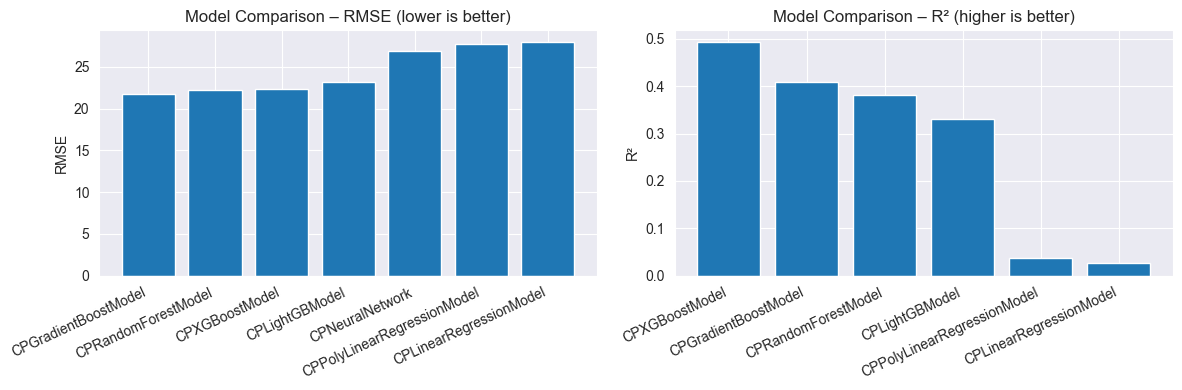

In [17]:
# Visualize results
import matplotlib.pyplot as plt
import pandas as pd

if results_df is None or results_df.empty:
    print("No results to plot.")
else:
    # Harmonize column name and coerce numerics
    df = results_df.rename(columns={"Type": "Model"}).copy()
    df["RMSE"] = pd.to_numeric(df["RMSE"], errors="coerce")
    df["R2"]   = pd.to_numeric(df["R2"],   errors="coerce")

    # Order by RMSE (ascending), drop NaNs per panel
    rmse_df = df.dropna(subset=["RMSE"]).sort_values("RMSE")
    r2_df   = df.dropna(subset=["R2"]).sort_values("R2", ascending=False)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # RMSE
    axes[0].bar(rmse_df["Model"], rmse_df["RMSE"])
    axes[0].set_title("Model Comparison – RMSE (lower is better)")
    axes[0].set_ylabel("RMSE")
    axes[0].set_xticklabels(rmse_df["Model"], rotation=25, ha="right")

    # R²
    axes[1].bar(r2_df["Model"], r2_df["R2"])
    axes[1].set_title("Model Comparison – R² (higher is better)")
    axes[1].set_ylabel("R²")
    axes[1].set_xticklabels(r2_df["Model"], rotation=25, ha="right")

    plt.tight_layout()
    plt.show()



o## Analysis of results

Given the fact that Cedar Point traffic is inherently noisy data the results in general are not bad.  XGBoost in particular appears to be a good model, explaining over 54% of the variance in crowd levels with an average off value of 21.


### Use Model for test prediction

In [18]:
from cpml.predictive.predictor import CPPredictor
from datetime import date

# --- Configuration ---
predictor = CPPredictor(storage_dir=STORAGE_DIR)

# --- Create and run a prediction ---
prediction_date = date(2024,10, 31)
predicted_crowd = predictor.predict(prediction_date, actual_temp=50, actual_rain=0)

print(f"Predicted crowd level for {prediction_date}: {predicted_crowd:.3f}")
print("Model used:", predictor.model_path())
print("Model metrics:", predictor.model_metrics())
print("Feature count:", len(predictor.model_feature_names()))

Predicted crowd level for 2024-10-31: 46.000
Model used: C:\Users\rober\PycharmProjects\CedarPointMLModel\storage\artifacts\latest\gradient_boost-20251113-154536.meta.json
Model metrics: {'r2': 0.40965506175037036, 'rmse': 21.777710126194986}
Feature count: 18
